In [1]:
# triplet phase closure 

# use kernel "myjupyter"
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter, uniform_filter
from extract_transect import extract_transect
%matplotlib  widget

In [96]:
# how many dates do we have? 
workdir = '/data/ocp4/LagunaSalada/'
# started with alooks=4, rlooks=20
alooks=40
rlooks=200

#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'

LSx=14500
LSy=1800
notLSx=16000
notLSy=1800

# two different points, one has larger magnitude tpc after storm 
pixx=9962
pixy=1295
pixx2=9897
pixy2=1484

# for lab meeting presentation 6-17-22
LSx=9234 
LSy=1345
notLS2=10000
notLS2=1500 


# for poster 10-30-22
LSx=15000
LSy=1500
notLSx=16500
notLSy=1500
# these are in agriculture fields 
#LSx=14000 # this is the point right next to LS with TPC anomaly 
#LSy=3400
#notLSx=5610 # this is an agricultural field 
#notLSy=965


dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
nd=len(dates)
print(str(nd)+' dates!') 

211 dates!


In [97]:
# initializing empty arrays, they are 3 dimensional 
# will contain a layer for each date 
# with layer containing alooks x rlooks pixels from each SLC
LS=np.ndarray([len(dates),alooks,rlooks],'complex')
NotLS=np.ndarray([len(dates),alooks,rlooks],'complex')

# pull out the alooks x rlooks box of pixels 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                    gdal.GA_ReadOnly)
    LS[i,:,:] = ds.GetRasterBand(1).ReadAsArray(LSx-rlooks/2,LSy-alooks/2, \
                                                   rlooks,alooks)

# do the same for the pixel just outside of CP geotherm field 
for i in np.arange(nd):
    ds = gdal.Open(workdir+cropdir+"SLC_vv/"+dates[i]+"/"+dates[i]+".slc.full", \
                   gdal.GA_ReadOnly)
    NotLS[i,:,:] = ds.GetRasterBand(1).ReadAsArray(notLSx-rlooks/2, \
                                                      notLSy-alooks/2,rlooks,alooks)

In [98]:
# calculate triplet phase closure
# initialize arrays
LStpc=np.ndarray([len(dates)-2],'complex')
NotLStpc=np.ndarray([len(dates)-2],'complex')

#print(np.shape(LStpc)); print(np.shape(NotLStpc))
#print(len(np.arange(1,nd,1))); print(nd)

skip1 = LS[0:-1,:,:]*np.conj(LS[1:,:,:]) # makes igrams first
skip2 = LS[2:,:,:]*np.conj(LS[0:-2,:,:])
#####Could normalize all of these by amplitude before taking the mean, tooo!!!
#skip1 = skip1/abs(skip1)
#skip2 = skip2/abs(skip2)
skip1 = np.mean(skip1,axis=(1,2)) # now average them (same as downlooking)
skip2 = np.mean(skip2,axis=(1,2))

# exclude the 0th term and the last term 
for i in np.arange(0,nd-2,1):
    ab = skip1[i]
    bc = skip1[i+1]
    ca = skip2[i]
    ab = np.exp(1j*np.angle(ab)) # normalizing to length 1
    bc = np.exp(1j*np.angle(bc)) # same as bc/abs(bc)
    ca = np.exp(1j*np.angle(ca))
    LStpc[i] = ab*bc*ca
    
skip1 = NotLS[0:-1,:,:]*np.conj(NotLS[1:,:,:]) # makes igrams first
skip2 = NotLS[2:,:,:]*np.conj(NotLS[0:-2,:,:])
#####Could normalize all of these by amplitude before taking the mean, tooo!!!
#skip1 = skip1/abs(skip1)
#skip2 = skip2/abs(skip2)
skip1 = np.mean(skip1,axis=(1,2)) # now average them (same as downlooking)
skip2 = np.mean(skip2,axis=(1,2))   
    
for i in np.arange(0,nd-2,1):
    ab = skip1[i]
    bc = skip1[i+1]
    ca = skip2[i]
    ab = np.exp(1j*np.angle(ab)) # normalizing to length 1
    bc = np.exp(1j*np.angle(bc)) # same as bc/abs(bc)
    ca = np.exp(1j*np.angle(ca))
    NotLStpc[i] = ab*bc*ca

In [99]:
# convert date strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))

In [100]:
# Read in precipitation data and plot it 
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip.txt', delimiter=',', skiprows=3, dtype=str)
precipDates = precip[:,0]; precip = precip[:,1]
precip = precip.astype(float)
# convert to cm from inches 
precip = precip*2.54

# make the dates from precip.txt into datetime objects
my_dates=[]
for i in range(0,len(precipDates)):
    my_dates.append(datetime.strptime(str(precipDates[i]).replace('\n',''), '%Y-%m-%d'))

In [101]:
# Calculate average coherence over three SLCs to color each tpc point 
# initialize empty arrays 
cohLS = np.zeros([nd])
cohNotLS = np.zeros([nd])

# calculate coherence for each date/SLC 
for i in np.arange(nd-1): 
    # Using this method: <a b*> / <abs(a b*)>
    # a b*
    ints=LS[i,:,:] * np.conj(LS[i+1,:,:]) # same as skip1
    ints2=NotLS[i,:,:] * np.conj(NotLS[i+1,:,:])
    # <a b*> / <abs(a b*)> complex coherence 
    cohLS[i]=np.abs(np.mean(ints,axis=(0,1))/np.mean(np.abs(ints),axis=(0,1))) 
    cohNotLS[i]=np.abs(np.mean(ints2,axis=(0,1))/np.mean(np.abs(ints2),axis=(0,1)))
    
# initialize arrays for average coh over 3 dates
cohAvgLS = np.zeros([nd-2])
cohAvgNotLS = np.zeros([nd-2])

# calculate avg coherence for each triplet
for i in np.arange(nd-2):
    cohAvgLS[i] = np.mean(cohLS[i:i+3])
    cohAvgNotLS[i] = np.mean(cohNotLS[i:i+3])

In [102]:
# Read in 2-day precipitation data
precip2 = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')

# BIGGER STORMS
# days with precip > 0.3cm 
print('date \t\t       precip > 0.3cm')
rain_dates = []
for i in np.arange(len(precip2)): 
    if precip2[i] > 0.3:
        print(str(slc_dates[i])+'    '+str(precip2[i])+' cm')
        rain_dates.append(slc_dates[i])

date 		       precip > 0.3cm
2017-05-10 00:00:00    0.33020000000000005 cm
2018-12-07 00:00:00    5.0546 cm
2019-09-27 00:00:00    1.4478 cm
2019-11-20 00:00:00    2.286 cm
2020-02-12 00:00:00    1.1684 cm
2020-03-13 00:00:00    0.40640000000000004 cm
2020-04-12 00:00:00    0.9906 cm
2021-08-11 00:00:00    0.381 cm


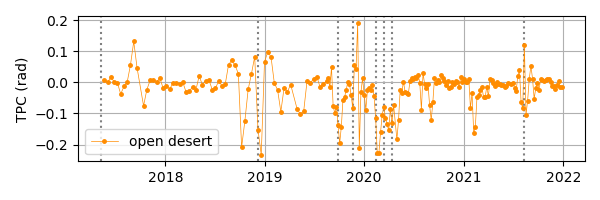

In [106]:
# plot it
plt.figure(figsize=(6, 2), tight_layout=True)
ax = plt.subplot(1, 1, 1)
ax.set_ylabel('TPC (rad)')
#plt.xlabel('time')
#ax.plot(slc_dates[1:-1],np.angle(LStpc),'ko',ms=4,label='pixel in TPC anomaly')
#ax.plot(slc_dates[1:-1],np.angle(NotLStpc),'wo',ms=4,mec='k', \
#        label='pixel outside of TPC anomaly')
#ax.plot(slc_dates[1:-1],np.angle(LStpc),'.-',ms=5,color='purple', \
#        linewidth=0.5,label='Laguna Salada',zorder=3)
ax.plot(slc_dates[1:-1],np.angle(NotLStpc),'.-',ms=5,color='darkorange', \
        linewidth=0.5,label='open desert',zorder=10)
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=0)
plt.ylim([Ymin,Ymax])
#plt.xlim([slc_dates[1],slc_dates[-1]])

ax.grid('on')
#plt.legend(bbox_to_anchor=(0.25, 1)) #plt.legend(loc='upper left')
plt.legend()

#zoomed in 
#plt.xlim([datetime(2019, 7, 1, 0, 0), datetime(2020, 7, 1, 0, 0)])
#ax2 = ax.twinx()
#ax2.plot(my_dates,precip,'-b')
#plt.ylabel('precipitation (cm)')
plt.show()
plt.savefig("tpc_time_desert.png", transparent=True)

In [89]:
print(np.sum(np.angle(LStpc)))

-18.436709307877983


In [ ]:
# Calculate average values 
avgLS = np.mean(np.angle(LStpc))
avgNotLS = np.mean(np.angle(NotLStpc))

print("Average triplet phase closure in LS: "+str(avgLS))
print("Average triplet phase closure out of LS: "+str(avgNotLS))

In [ ]:
# ZOOMED IN on Y-axis and plot horizontal line at zero
plt.figure(figsize=(8, 4), tight_layout=True)
ax = plt.subplot(1, 1, 1)
# alpha=0.5 gives it half transparency (1 is opaque, 0 is transparent)
ax.axhline(y=0,color='k', zorder=1, alpha=0.5) 
ax.set_ylabel('triplet phase closure')
#ax.set_ylim([-0.2,0.2])
plt.xlabel('time')
plt.plot(slc_dates[1:-1],np.angle(LStpc),'r-')
plt.scatter(slc_dates[1:-1],np.angle(LStpc),c=cohAvgLS,label='pixel in Laguna Salada',zorder=3)
#ax.plot(slc_dates[1:-1],np.angle(NotLStpc),c=cohAvgNotLS,mec='k', \
#        label='pixel outside of Laguna Salada')
cbar = plt.colorbar(pad=0.08)
cbar.set_label('avg coherence over 3 dates')
#ax.grid('on')
#plt.legend(bbox_to_anchor=(0.25, 1)) #plt.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(my_dates,precip,'-b',zorder=2)
plt.ylabel('precipitation (cm)')
plt.show()

In [ ]:
# try uniform and gaussian filter and plot them 
LStpcUniformFilt = uniform_filter(LStpc, size=5)
LStpcGauFilt = gaussian_filter(LStpc, sigma=5)

plt.figure(figsize=(8, 4), tight_layout=True)
ax = plt.subplot(1, 1, 1)
ax.axhline(y=0,color='k') # WHY DOES THIS PLOT ON TOP?
ax.set_ylabel('triplet phase closure')
#ax.set_ylim([-0.15,0.15])
plt.xlabel('time')
plt.scatter(slc_dates[1:-1],np.angle(LStpc),c=cohAvgLS,label='pixel in Laguna Salada')
#ax.plot(slc_dates[1:-1],np.angle(NotLStpc),c=cohAvgNotLS,mec='k', \
#        label='pixel outside of Laguna Salada')
cbar = plt.colorbar()
cbar.set_label('avg coherence over 3 dates')
ax.plot(slc_dates[1:-1],np.angle(LStpcGauFilt),'r-',label='Gaussian filter')
#ax.grid('on')
#plt.legend(bbox_to_anchor=(0.25, 1)) 
plt.legend(loc='lower right')
#ax2 = ax.twinx()
#ax2.plot(my_dates,precip,'-b')
#plt.ylabel('precipitation (cm)')
plt.title('Gaussian filter, sigma=5')
plt.show()

IDEA?: 
color triplet phase closure by average rainfall in that date range 

In [ ]:
# try plotting triplet phase closure during 2018 storm 
# over full region spatially 
date1='20181113'
date2='20181125'
date3='20181207'
date4='20181219'

x1=0; dx=18000; y1=0; dy=3600
alooks=4; rlooks=20

ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date3+"/"+date3+".slc.full", gdal.GA_ReadOnly)
slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date4+"/"+date4+".slc.full", gdal.GA_ReadOnly)
slc4 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

# 4 SLCs, can make 3 sequential igrams
int12 = slc1 * np.conj(slc2)
int23 = slc2 * np.conj(slc3)
int34 = slc3 * np.conj(slc4)
# and 2 nonsequential (skip a date)
int31 = slc3 * np.conj(slc1)
int42 = slc4 * np.conj(slc2)

# normalizing, didn't change anything 
int12 = np.exp(1j*np.angle(int12))
int23 = np.exp(1j*np.angle(int23))
int34 = np.exp(1j*np.angle(int34))
int31 = np.exp(1j*np.angle(int31))
int42 = np.exp(1j*np.angle(int42))


# now filter them by alooks/rlooks 
int12filt = uniform_filter((int12), size=[alooks,rlooks])
int23filt = uniform_filter((int23), size=[alooks,rlooks])
int34filt = uniform_filter((int34), size=[alooks,rlooks])
int31filt = uniform_filter((int31), size=[alooks,rlooks])
int42filt = uniform_filter((int42), size=[alooks,rlooks])

tpc123 = np.angle(int12filt*int23filt*int31filt)
tpc234 = np.angle(int23filt*int34filt*int42filt)


In [ ]:
# plot tpc 
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(tpc123,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
           interpolation='nearest')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(date1)+"-"+str(date2)+"-"+str(date3))
plt.colorbar()
plt.xlim(dx, 0)

plt.subplot(1,2,2)
plt.imshow(tpc234,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
           interpolation='nearest')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(date2)+"-"+str(date3)+"-"+str(date4))
plt.colorbar()
plt.xlim(dx, 0)
plt.show()

In [ ]:
# average across this scene for each date triplet:
print(str(date1)+"-"+str(date2)+"-"+str(date3)+" average = "+str(np.mean(tpc123)))
print(str(date2)+"-"+str(date3)+"-"+str(date4)+" average = "+str(np.mean(tpc234)))

# what is the average triplet phase closure just in 2018? 
    # is this the right calculation?
tpc2018 = np.mean(np.angle(LStpc[19:50]))
print("for 2018: "+str(tpc2018))





The big rain was on 12-7-2018

In [ ]:
# try plotting triplet phase closure AFTER 2018 storm FOR REFERENCE
# over full region spatially 
date1='20181020'
date2='20181101'
date3='20181113'
date4='20181125'

date1='20190112'
date2='20190124'
date3='20190205'
date4='20190217'

x1=0; dx=18000; y1=0; dy=3600
alooks=4; rlooks=20

ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date3+"/"+date3+".slc.full", gdal.GA_ReadOnly)
slc3 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date4+"/"+date4+".slc.full", gdal.GA_ReadOnly)
slc4 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)

# 4 SLCs, can make 3 sequential igrams
int12 = slc1 * np.conj(slc2)
int23 = slc2 * np.conj(slc3)
int34 = slc3 * np.conj(slc4)
# and 2 nonsequential (skip a date)
int31 = slc3 * np.conj(slc1)
int42 = slc4 * np.conj(slc2)

# now filter them by alooks/rlooks 
int12filt = uniform_filter((int12), size=[alooks,rlooks])
int23filt = uniform_filter((int23), size=[alooks,rlooks])
int34filt = uniform_filter((int34), size=[alooks,rlooks])
int31filt = uniform_filter((int31), size=[alooks,rlooks])
int42filt = uniform_filter((int42), size=[alooks,rlooks])

# normalizing, didn't change anything 
#int12filt = np.exp(1j*np.angle(int12filt))
#int23filt = np.exp(1j*np.angle(int23filt))
#int34filt = np.exp(1j*np.angle(int34filt))
#int31filt = np.exp(1j*np.angle(int31filt))
#int42filt = np.exp(1j*np.angle(int42filt))

tpc123 = np.angle(int12filt*int23filt*int31filt)
tpc234 = np.angle(int23filt*int34filt*int42filt)


In [ ]:
# try plotting the downsampled interferogram 
plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(tpc123,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
           interpolation='nearest') # previously had cmap='jet'
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(date1)+"-"+str(date2)+"-"+str(date3))
plt.colorbar()
plt.xlim(dx, 0)

plt.subplot(1,2,2)
plt.imshow(tpc234,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
           interpolation='nearest')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(date2)+"-"+str(date3)+"-"+str(date4))
plt.colorbar()
plt.xlim(dx, 0)
plt.show()

In [ ]:
# average across this scene for each date triplet:
print(str(date1)+"-"+str(date2)+"-"+str(date3)+" average = "+str(np.mean(tpc123)))
print(str(date2)+"-"+str(date3)+"-"+str(date4)+" average = "+str(np.mean(tpc234)))

In [ ]:
# plot just a single one to more easily zoom in 
plt.figure(figsize=(10, 12))
plt.imshow(tpc123,vmin=-np.pi/4, vmax=np.pi/4, cmap='seismic', aspect='auto', \
           interpolation='nearest') # previously had cmap='jet'
startx=8000; endx=11000; starty=1100; endy=1800
plt.gca().add_patch(Rectangle((startx,starty), endx-startx, endy-starty,
                    edgecolor='k',
                    facecolor='none',
                    lw=3))
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("triplet phase closure \n"+str(date1)+"-"+str(date2)+"-"+str(date3))
plt.colorbar()
plt.xlim(dx, 0)
plt.show()

<br> Next: take a transect of TPC across the western border of Laguna Salada and animate it over time <br> <br>

Bring in my extract_transect tool to see what TPC is doing over the western shoreline of Laguna Salada. Also this will test my transect tool.

In [ ]:
x1 = 9234
x2 = 10000
y1 = 1345
y2 = 1500

startPt = [startx, starty]
endPt = [endx, endy]
transect = extract_transect(tpc123, startPt, endPt, 10, 30)

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(np.real(transect[0]),np.real(transect[1]),'r.-',markersize=5)
plt.ylabel('TPC'); plt.xlabel('profile dist')
plt.show()